In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Load data and generate some features of interest

In [3]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


In [4]:
type(eeg)

dict

In [5]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

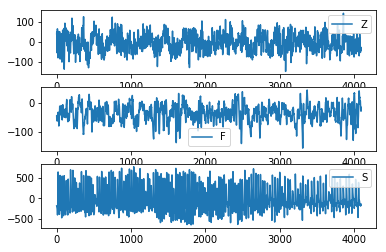

In [6]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [7]:
type(eeg["measurements"][0])

numpy.ndarray

In [8]:
type(eeg)

dict

In [9]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [10]:
type(eeg['measurements'])

list

In [11]:
len(eeg['measurements'])

500

In [12]:
eeg['measurements'][0].shape

(4097,)

## Generate the features

In [13]:
# from cesium import featurize as ft
# features_to_use = ["amplitude",
#                    "percent_beyond_1_std",
#                    "percent_close_to_median",
#                   "skew",
#                   "max_slope"]
# fset_cesium = ft.featurize_time_series(times=eeg["times"],
#                                               values=eeg["measurements"],
#                                               errors=None,
#                                               features_to_use=features_to_use,
#                                              scheduler = None)

In [14]:
fset_cesium = pd.read_csv("data/full_eeg_data_features.csv", header = [0, 1])

In [15]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


In [16]:
# fset_cesium.to_csv("full_eeg_data_features.csv")

In [17]:
fset_cesium.shape

(500, 6)

In [18]:
fset_cesium.shape

(500, 6)

## Exercise: validate/calculate these features by hand
#### look up feature definitions here: http://cesium-ml.org/docs/feature_table.html
confirm the values by hand coding these features for the first EEG measurement
(that is eeg["measurements"][0])

In [19]:
ex = eeg["measurements"][0]

In [20]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)

In [21]:
# amplitude
(np.max(ex) - np.min(ex)) / 2

143.5

In [22]:
 
siz = len(ex)
ll = ex_mean - ex_std
ul = ex_mean + ex_std

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [23]:
# percent_close_to_median
# Percentage of values within window_frac*(max(x)-min(x)) of median.
# find the source code here:
# https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
# window frac = 0.1
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <a list of 10 Patch objects>)

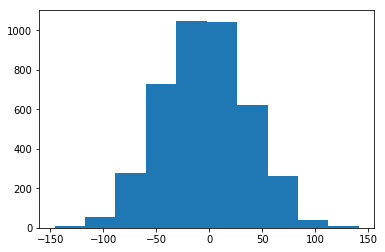

In [24]:
## skew
print(skew(ex))
plt.hist(ex)

In [25]:
## max slope
## again check definition : https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

(array([311.,  85.,  30.,  19.,   8.,  13.,   7.,  14.,   7.,   6.]),
 array([  63. ,  241.5,  420. ,  598.5,  777. ,  955.5, 1134. , 1312.5,
        1491. , 1669.5, 1848. ]),
 <a list of 10 Patch objects>)

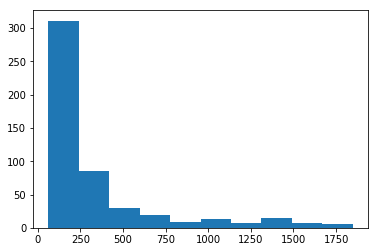

In [26]:
plt.hist(fset_cesium.iloc[:, 1])

In [27]:
fset_cesium['classes'] = eeg['classes']

In [28]:
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: amplitude, dtype: object

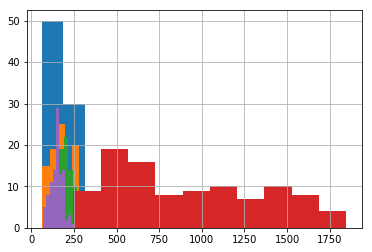

In [29]:
fset_cesium.groupby('classes')['amplitude'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcea4d12be0>,
      dtype=object)

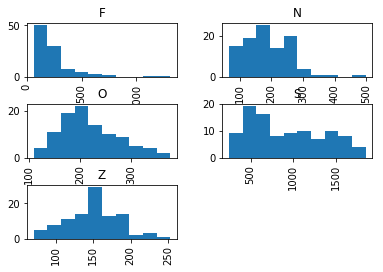

In [30]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcea4a53898>,
      dtype=object)

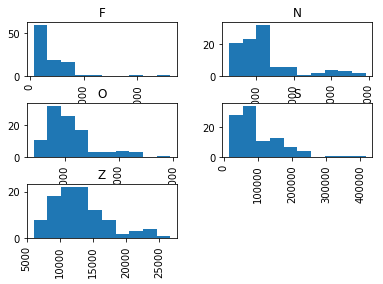

In [31]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

## Prepare data for training

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
     fset_cesium.iloc[:, 1:6].values, eeg["classes"], random_state=21)

In [34]:
X_train[:, 0]

array([1067.5,  183.5,  225. ,  705.5,   88. ,   93. ,  111.5,  193. ,
        256. ,  258.5,  201. ,  354.5,  199.5,  152. ,  188.5,  250. ,
        550. ,  217. ,  130.5,  561.5,  220. , 1392.5,  155.5,  201. ,
        159. ,  102. ,  197. , 1848. ,   91. ,  119. ,  272. ,  352.5,
        232.5,  178.5, 1501. ,  159.5,  159. ,  213. ,  131.5,  279.5,
       1370. ,  162. ,  197.5,  161. ,  157.5,  335.5,  159.5,  217.5,
        184. ,   93.5,  167. ,  196. ,  298.5,  490.5,  200. ,  262. ,
        203.5,  178. , 1725. ,  181.5,  135. , 1196.5,  518. ,  242. ,
        492. ,  146.5,  139.5,   91. ,   87.5,  887.5,  255. , 1670.5,
       1359. , 1343.5,  217.5,  218. ,  321.5,  105. ,  394.5,  161. ,
        194.5,  188.5,  180. ,  197.5,  236.5,   93.5,  154.5,  139. ,
        157. ,  232.5,  104. ,  110.5,  608. ,  178.5,  169. ,  163. ,
        141.5,  279.5,  158. ,  148.5, 1465. ,  189. ,   75.5,  169. ,
        162.5,  278.5,  269. ,   70. ,  152. ,  164. ,  116.5,  255. ,
      

## Try a random forest with these features

In [35]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [36]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [37]:
clf.score(X_train, y_train)

0.6266666666666667

In [38]:
clf.score(X_test, y_test)

0.616

In [39]:
np.unique(y_test, return_counts=True)

(array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1'), array([20, 29, 21, 25, 30]))

In [40]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N'], dtype='<U1')

In [41]:
y_test.shape

(125,)

In [42]:
y_train.shape

(375,)

## Try XGBoost with these features

In [43]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=21,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
accuracy_score(y_test, model.predict(X_test))

0.648

In [45]:
model.score(X_test, y_test)

0.648

In [46]:
model.score(X_train, y_train)

0.752

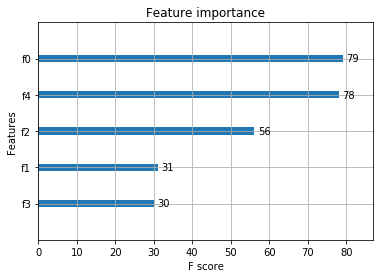

In [47]:
xgb.plot_importance(model)

## Time Series Forecasting with Decision Trees

In [48]:
ap = pd.read_csv("data/AirPassengers.csv", parse_dates=[0])

In [49]:
ap.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [50]:
ap.set_index('Month', inplace=True)

In [51]:
ap.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


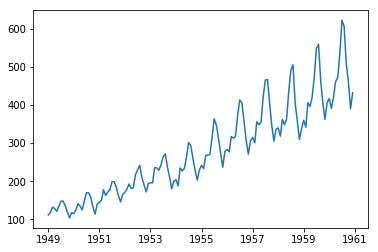

In [52]:
plt.plot(ap)

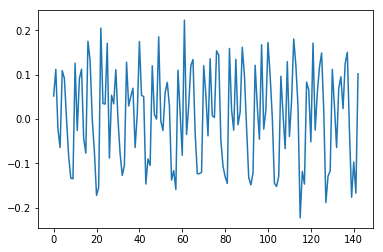

In [53]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

In [54]:
ts = np.diff(np.log(ap.values[:, 0]))

## Exercise: now that we have 1 time series, how can we convert it to many samples?

In [55]:
NSTEPS = 12

In [56]:
ts.shape

(143,)

In [57]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(NSTEPS )])

In [58]:
ts[0:NSTEPS]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ])

In [59]:
vals.shape

(143, 12)

In [60]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [61]:
vals

array([[ 0.05218575,  0.1121173 , -0.02298952, ..., -0.13473259,
         0.12629372, -0.0257525 ],
       [ 0.1121173 , -0.02298952, -0.06402186, ...,  0.12629372,
        -0.0257525 ,  0.09134978],
       [-0.02298952, -0.06402186,  0.10948423, ..., -0.0257525 ,
         0.09134978,  0.11247798],
       ...,
       [-0.0970834 , -0.1672513 ,  0.10227885, ...,         nan,
                nan,         nan],
       [-0.1672513 ,  0.10227885,         nan, ...,         nan,
                nan,         nan],
       [ 0.10227885,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [62]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [63]:
vals.shape

(132, 12)

In [64]:
vals[-1]

array([ 0.02919916, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067334, -0.02606011, -0.17639855, -0.0970834 ,
       -0.1672513 ,  0.10227885], dtype=float32)

In [65]:
ts[-NSTEPS:]

array([ 0.02919915, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067335, -0.02606011, -0.17639854, -0.0970834 ,
       -0.1672513 ,  0.10227885])

In [66]:
vals.shape

(132, 12)

## Exercise: now that we have the time series broken down into a set of samples, how to featurize?

In [67]:
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [68]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [69]:
measures[0]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629372], dtype=float32)

In [70]:
len(measures[0])

11

In [71]:
features_to_use = [
                   "amplitude",
                   "percent_beyond_1_std",
                   "skew",
                   "max_slope",
                   "percent_amplitude"]
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)

/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_m

/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/lomb_scargle.py:253: RuntimeWarning: invalid value encountered in sqrt
  out_dict['trend_error'] = np.sqrt(np.diag(vmodl0))
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/lomb_scargle.py:256: RuntimeWarning: invalid value encountered in sqrt
  damp = np.sqrt(A0**2 * vA0 + B0**2 * vB0 + 2. * A0 * B0 * covA0B0) / amp
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/lomb_scargle.py:266: RuntimeWarning: invalid value encountered in sqrt
  dphase[j] = np.sqrt(np.dot(np.dot(v, m), v))
/home/aileen/.local/lib/python3.6/site-packages/cesiu

/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_m

/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_m

/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/aileen/.local/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/aileen/.local/lib/python3.6/site-packages/numpy/core/_m

In [72]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [73]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


(array([15.,  7.,  5., 23., 26., 17.,  6.,  6., 16., 11.]),
 array([0.12786029, 0.1352786 , 0.14269691, 0.15011522, 0.15753352,
        0.16495183, 0.17237014, 0.17978845, 0.18720675, 0.19462506,
        0.20204337]),
 <a list of 10 Patch objects>)

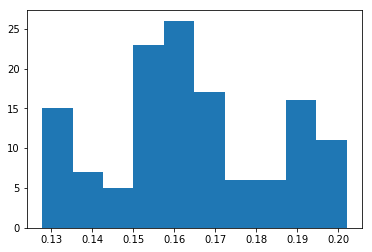

In [74]:
plt.hist(fset_ap.amplitude)

(array([16., 40., 35.,  4., 15.,  9.,  1.,  9.,  2.,  1.]),
 array([0.12414427, 0.14138614, 0.15862801, 0.17586988, 0.19311176,
        0.21035363, 0.2275955 , 0.24483737, 0.26207924, 0.27932111,
        0.29656298]),
 <a list of 10 Patch objects>)

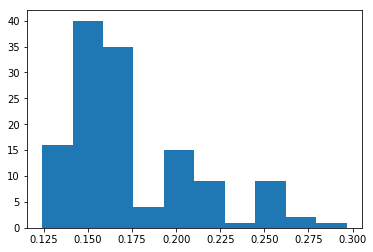

In [75]:
plt.hist(fset_ap.percent_amplitude)

(array([ 9., 11.,  8., 23., 26., 25., 18.,  9.,  2.,  1.]),
 array([-0.56547007, -0.45117751, -0.33688495, -0.22259239, -0.10829984,
         0.00599272,  0.12028528,  0.23457784,  0.3488704 ,  0.46316296,
         0.57745551]),
 <a list of 10 Patch objects>)

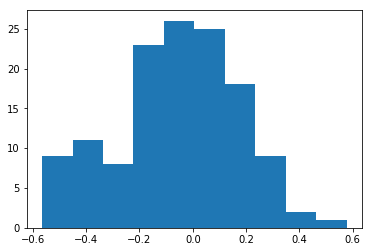

In [76]:
plt.hist(fset_ap['skew'])

## Exercise: can you fit an XGBRegressor to this problem? Let's use the first 100 'time series' as the training data

In [77]:
outcomes = vals[:, -1]

In [78]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [79]:
X_train.shape

(100, 5)

In [80]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)

In [81]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.467759
[1]	validation_0-rmse:0.425064
[2]	validation_0-rmse:0.386848
[3]	validation_0-rmse:0.35241
[4]	validation_0-rmse:0.321675
[5]	validation_0-rmse:0.294493
[6]	validation_0-rmse:0.270009
[7]	validation_0-rmse:0.248279
[8]	validation_0-rmse:0.235445
[9]	validation_0-rmse:0.218315
[10]	validation_0-rmse:0.208481
[11]	validation_0-rmse:0.195013
[12]	validation_0-rmse:0.187017
[13]	validation_0-rmse:0.180676
[14]	validation_0-rmse:0.171583
[15]	validation_0-rmse:0.163638
[16]	validation_0-rmse:0.156489
[17]	validation_0-rmse:0.150463
[18]	validation_0-rmse:0.145529
[19]	validation_0-rmse:0.138919


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

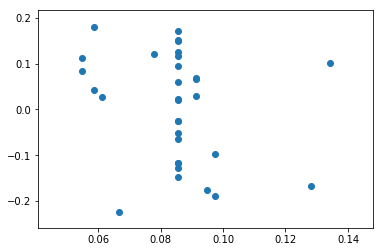

In [82]:
plt.scatter(model.predict(X_test), y_test)

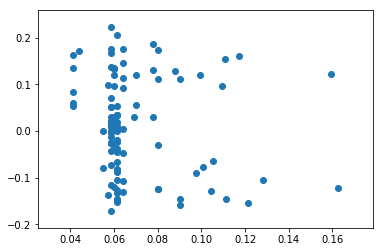

In [83]:
plt.scatter(model.predict(X_train), y_train)

In [84]:
pearsonr(model.predict(X_train), y_train)

(-0.13019356, 0.19667944650210115)

In [85]:
pearsonr(model.predict(X_test), y_test)

(-0.24773927, 0.17159711920699539)

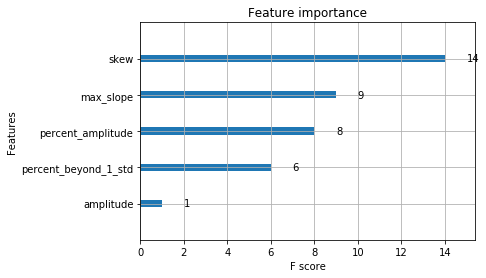

In [86]:
xgb.plot_importance(model)

## We need to find a way to generate features that encode positional information

In [87]:
## now we will generate our own features

In [88]:
vals.shape

(132, 12)

In [89]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [90]:
feats[0:3]

array([[10.        ,  9.        ,  1.        ,  0.12629372, -0.15204622,
         0.10898009],
       [ 9.        ,  8.        ,  1.        ,  0.12629372,  0.11710228,
        -0.03494394],
       [ 8.        ,  7.        ,  1.        ,  0.11247798,  0.0211282 ,
         0.13823047]], dtype=float32)

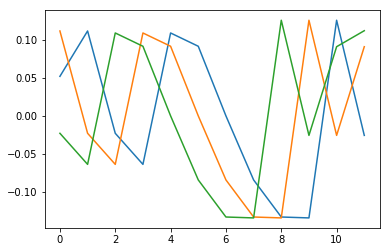

In [91]:
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])

In [92]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [93]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.467759
[1]	validation_0-rmse:0.425064
[2]	validation_0-rmse:0.386848
[3]	validation_0-rmse:0.35241
[4]	validation_0-rmse:0.321675
[5]	validation_0-rmse:0.294493
[6]	validation_0-rmse:0.269802
[7]	validation_0-rmse:0.249599
[8]	validation_0-rmse:0.231346
[9]	validation_0-rmse:0.214722
[10]	validation_0-rmse:0.201125
[11]	validation_0-rmse:0.188284
[12]	validation_0-rmse:0.177724
[13]	validation_0-rmse:0.168863
[14]	validation_0-rmse:0.160408
[15]	validation_0-rmse:0.154006
[16]	validation_0-rmse:0.147978
[17]	validation_0-rmse:0.142052
[18]	validation_0-rmse:0.138151
[19]	validation_0-rmse:0.135491


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

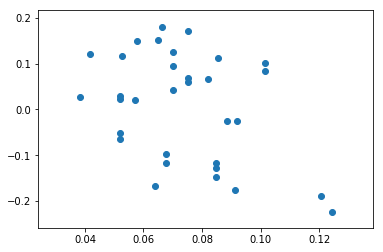

In [94]:
plt.scatter(model.predict(X_test), y_test)

In [95]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

(-0.40141273, 0.022779505117070775)
SpearmanrResult(correlation=-0.2716009089025262, pvalue=0.13265640506451284)


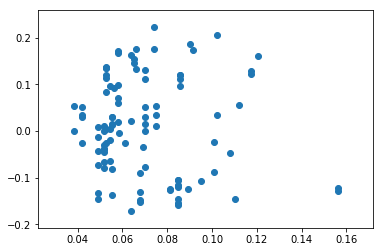

In [96]:
plt.scatter(model.predict(X_train), y_train)

In [97]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

(-0.075795464, 0.4535532719826483)
SpearmanrResult(correlation=0.016280197595743676, pvalue=0.8722778702202889)
